In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git


import sklearn
import sklearn.cluster
 

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA


import matplotlib.cm #Still for graphics


#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os
java_path = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path

import os.path #For managing file paths

import nltk #For stop words and stemmers

import lucem_illud.stanford as stanford # for claim extraction

import re # for regex

import copy # for linguistic change

D:\computation\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\computation\Anaconda3\lib\site-packages\nltk\tag\stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
D:\computation\Anaconda3\lib\site-packages\nltk\tag\stanford.py:149: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordPOSTagger, self).__init__(*args, **kwargs)


In [2]:
nyt = pandas.read_csv('D:/contentAnalysis/vietnam/nyt2000.csv')

nyt84 = nyt[nyt['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
nyt89 = nyt[nyt['date'].str.contains('1985|1986|1987|1988|1989', na = False)]
nyt94 = nyt[nyt['date'].str.contains('1990|1991|1992|1993|1994', na = False)]
nyt99 = nyt[nyt['date'].str.contains('1995|1996|1997|1998|1999', na = False)]

# Corpus Linguistics

In [92]:
nytCorpLing = nyt

snowball = nltk.stem.snowball.SnowballStemmer('english')

#nytCorpLing['tokenized_text'] = nytCorpLing['article'].apply(lambda x: nltk.word_tokenize(x))
nytCorpLing['normalized_tokens'] = nytCorpLing['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = snowball))

In [ ]:
nytBigrams = nltk.collocations.BigramCollocationFinder.from_words(nytCorpLing['normalized_tokens'].sum())
print("There are {} bigrams in the finder".format(nytBigrams.N))

In [102]:
print("There are {} bigrams in the finder".format(nytBigrams.N))

There are 13325011 bigrams in the finder


In [113]:
def bigramScoring(count, wordsTuple, total):
    return count

print(nytBigrams.nbest(bigramScoring, 30))

[('unit', 'state'), ('new', 'york'), ('english', 'graphic'), ('vietnam', 'war'), ('graphic', 'photo'), ('white', 'hous'), ('last', 'year'), ('year', 'ago'), ('soviet', 'union'), ('world', 'war'), ('unit', 'nation'), ('english', 'type'), ('offici', 'said'), ('last', 'week'), ('war', 'ii'), ('khmer', 'roug'), ('air', 'forc'), ('york', 'time'), ('vietnam', 'veteran'), ('vice', 'presid'), ('presid', 'reagan'), ('foreign', 'polici'), ('el', 'salvador'), ('high', 'school'), ('two', 'year'), ('york', 'citi'), ('prime', 'minist'), ('state', 'depart'), ('year', 'old'), ('los', 'angel')]


In [ ]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
nytTrigrams = nltk.collocations.TrigramCollocationFinder.from_words(nytCorpLing['normalized_tokens'].sum())
nytTrigrams.score_ngrams(trigram_measures.student_t)[:20]

# word2vec

#### prep corpus

In [3]:
nytDF = nyt

def cleanerYear(x):
    return re.sub(r'(\D+)\s(\d{1,2})\W', '', x)

nytDF['date'] = nytDF['date'].apply(cleanerYear)
nytDF['docID'] = nytDF.index

nytDF = nytDF.reset_index(drop=True)

#Apply our functions, notice each row is a list of lists now
nytDF['tokenized_sents'] = nytDF['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
nytDF['normalized_sents'] = nytDF['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = None) for s in x])



#### iter and dimension testing

In [98]:
# iter

nytW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
nytW2V_loss.build_vocab(nytDF['normalized_sents'].sum())
nytW2V_loss.train(nytDF['normalized_sents'].sum(), 
                     total_examples=nytW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [nytW2V_loss.running_training_loss]
losses[0]

9256326.0

In [ ]:
# iter

lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

In [ ]:
# dimensions

for i in range(19):
    nytW2V_loss.train(nytDF['normalized_sents'].sum(), 
                     total_examples=nytW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(nytW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

In [ ]:
# dimensions

losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

#### w2v doing its thing

In [4]:
nytW2V = gensim.models.word2vec.Word2Vec(nytDF['normalized_sents'].sum())

In [15]:
nytW2V.most_similar(positive=['vietnam', 'war', 'missing'])

[('indochina', 0.6871994137763977),
 ('unaccounted', 0.6217677593231201),
 ('servicemen', 0.6184337139129639),
 ('combat', 0.6050904989242554),
 ('laos', 0.5637581944465637),
 ('wartime', 0.5516078472137451),
 ('conflict', 0.5391845107078552),
 ('hanoi', 0.5248482823371887),
 ('battlefields', 0.5059446096420288),
 ('korea', 0.5054271817207336)]

In [303]:
nytW2V.most_similar('prisoners')

[('prisoner', 0.7905887961387634),
 ('servicemen', 0.7384381890296936),
 ('captives', 0.7081892490386963),
 ('detainees', 0.6654864549636841),
 ('hostages', 0.6464436054229736),
 ('deserters', 0.6186035871505737),
 ('inmates', 0.5860714912414551),
 ('defectors', 0.5734658241271973),
 ('captors', 0.5577869415283203),
 ('serviceman', 0.5458605885505676)]

In [17]:
nytW2V.most_similar('missing')


[('unaccounted', 0.7440609931945801),
 ('servicemen', 0.6481564044952393),
 ('listed', 0.6013747453689575),
 ('dead', 0.592308521270752),
 ('fate', 0.539675235748291),
 ('remains', 0.5281307697296143),
 ('alive', 0.5219168663024902),
 ('whereabouts', 0.5011625289916992),
 ('prisoners', 0.47272664308547974),
 ('search', 0.4711296558380127)]

In [7]:
numWords = 150
targetWords = nytW2V.wv.index2word[:numWords]

In [25]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(nytW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-1.4698645 ,  0.8078447 , -1.2409662 , ...,  2.4158332 ,
         1.5062152 ,  0.5487973 ],
       [-2.8091605 , -0.10851444, -0.9104403 , ...,  1.3965249 ,
         0.25948116,  1.4704249 ],
       [-0.07349849, -1.3920742 ,  0.16081643, ..., -0.17525397,
         0.93247485, -0.0958911 ],
       ...,
       [-2.804545  ,  0.55682176,  0.8765692 , ...,  1.1766677 ,
         1.943861  ,  1.596495  ],
       [-0.5529652 , -0.02375211,  0.05010545, ...,  0.7956565 ,
         0.8077774 , -1.2759283 ],
       [-1.3893946 ,  1.8083165 ,  1.0760838 , ...,  0.3107637 ,
        -0.26820454,  0.699477  ]], dtype=float32)

In [26]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

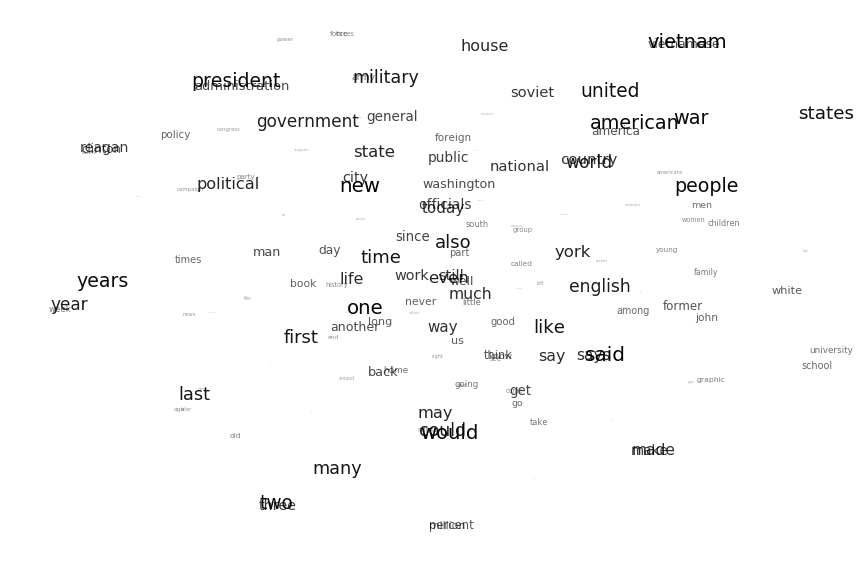

In [27]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

In [43]:
keywords = ['captivity', 'war', 'soviet', 'clinton', 'reagan', 'carter', 'nixon', 'missing', 'prisoners', 'vietnam']

In [44]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nytW2V.wv[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nytW2V.wv[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

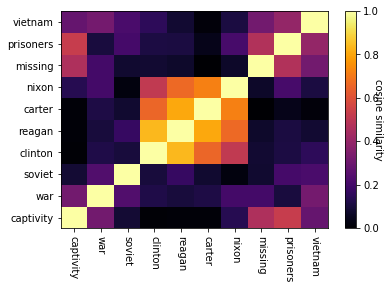

In [45]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='inferno')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('all.png', bbox_inches='tight')
fig.savefig('corpusHeat.png', bbox_inches='tight')

In [46]:
nyt84 = nytDF[nytDF['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
nyt89 = nytDF[nytDF['date'].str.contains('1985|1986|1987|1988|1989', na = False)]
nyt94 = nytDF[nytDF['date'].str.contains('1990|1991|1992|1993|1994', na = False)]
nyt99 = nytDF[nytDF['date'].str.contains('1995|1996|1997|1998|1999', na = False)]

In [19]:
nyt84W2V = gensim.models.word2vec.Word2Vec(nyt84['normalized_sents'].sum())

In [20]:
nyt89W2V = gensim.models.word2vec.Word2Vec(nyt89['normalized_sents'].sum())

In [21]:
nyt94W2V = gensim.models.word2vec.Word2Vec(nyt94['normalized_sents'].sum())

In [22]:
nyt99W2V = gensim.models.word2vec.Word2Vec(nyt99['normalized_sents'].sum())

In [304]:
keywords = ['captivity', 'war', 'clinton', 'reagan', 'carter', 'nixon', 'missing', 'prisoners', 'vietnam', 'economy', 'trade']

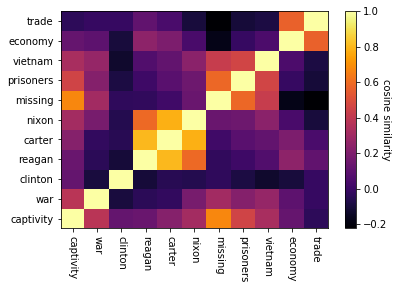

In [305]:
#84

heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nyt84W2V.wv[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nyt84W2V.wv[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)



fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='inferno')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('all.png', bbox_inches='tight')
fig.savefig('84heat.png', bbox_inches='tight')


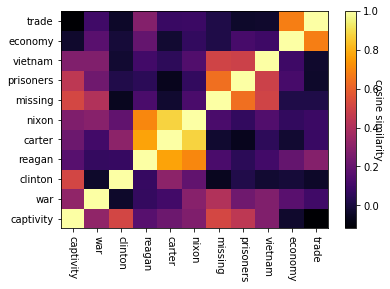

In [306]:
#89

heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nyt89W2V.wv[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nyt89W2V.wv[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)



fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='inferno')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('all.png', bbox_inches='tight')
fig.savefig('89heat.png', bbox_inches='tight')

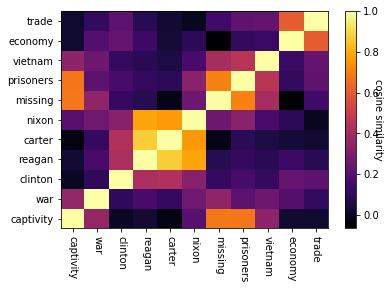

In [307]:
#94


heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nyt94W2V.wv[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nyt94W2V.wv[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)



fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='inferno')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('all.png', bbox_inches='tight')
fig.savefig('94heat.png', bbox_inches='tight')

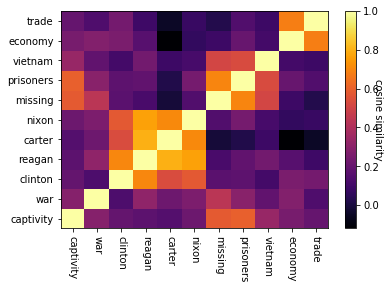

In [308]:
#99

heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = nyt99W2V.wv[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, nyt99W2V.wv[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)



fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='inferno')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)
plt.savefig('all.png', bbox_inches='tight')
fig.savefig('99heat.png', bbox_inches='tight')

#### dimensions

In [59]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

In [60]:
#Administration = dimension(nyt84W2V, ['reagan'], ['carter'])

Party = dimension(nyt84W2V, ['republican', 'conservative'], ['democrat', 'liberal'])

Gender = dimension(nyt84W2V, ['man'], ['woman'])
f
Branch = dimension(nyt84W2V, ['president'], ['congress', 'senate', 'house'])

In [80]:
nytW2V.most_similar('war')

[('wars', 0.709933876991272),
 ('conflict', 0.7081298828125),
 ('combat', 0.6047180891036987),
 ('battle', 0.595706045627594),
 ('battles', 0.5816576480865479),
 ('warfare', 0.5677369236946106),
 ('wartime', 0.5538725852966309),
 ('disobedience', 0.5497036576271057),
 ('strife', 0.53928542137146),
 ('battlefields', 0.5306195020675659)]

In [79]:
nytW2V.most_similar('missing')

[('unaccounted', 0.7440609931945801),
 ('servicemen', 0.6481564044952393),
 ('listed', 0.6013747453689575),
 ('dead', 0.592308521270752),
 ('fate', 0.539675235748291),
 ('remains', 0.5281307697296143),
 ('alive', 0.5219168663024902),
 ('whereabouts', 0.5011625289916992),
 ('prisoners', 0.47272664308547974),
 ('search', 0.4711296558380127)]

In [309]:
VietnamWar = ['captivity', 'prisoners', 'missing', 'remains', 'economy', 'trade']

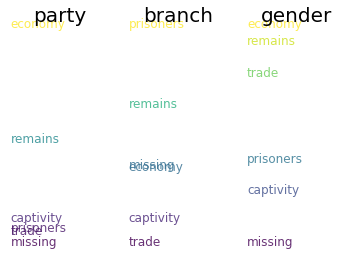

In [310]:
#Administration = dimension(nyt84W2V, ['reagan'], ['carter'])

Party = dimension(nyt84W2V, ['republican', 'conservative'], ['democrat', 'liberal'])

Gender = dimension(nyt84W2V, ['man'], ['woman'])

Branch = dimension(nyt84W2V, ['president'], ['congress', 'senate', 'house'])

def makeDF(model, word_list):
    g = []
    r = []
    c = []
    b = []
    for word in word_list:
        #g.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Administration.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nyt84W2V[word].reshape(1,-1), Party.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nyt84W2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        b.append(sklearn.metrics.pairwise.cosine_similarity(nyt84W2V[word].reshape(1,-1), Branch.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'party': r, 'gender': c, 'branch' : b}, index = word_list)
    return df

vietnamWarDF = makeDF(nyt89W2V, VietnamWar) 

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.viridis(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = .8, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())
    
fig = plt.figure(figsize = (6,4))
#ax1 = fig.add_subplot(141)
#PlotDimension(ax1, vietnamWarDF, 'administration')
ax1 = fig.add_subplot(131)
PlotDimension(ax1, vietnamWarDF, 'party')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, vietnamWarDF, 'branch')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, vietnamWarDF, 'gender')
plt.show()
fig.savefig('dimension84.png')

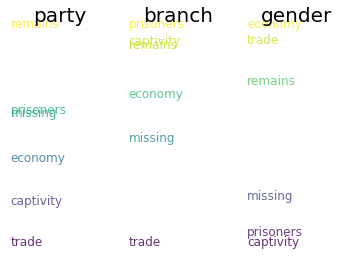

In [311]:
#Administration = dimension(nyt84W2V, ['reagan'], ['carter'])

Party = dimension(nyt89W2V, ['republican', 'conservative'], ['democrat', 'liberal'])

Gender = dimension(nyt89W2V, ['man'], ['woman'])

Branch = dimension(nyt89W2V, ['president'], ['congress', 'senate', 'house'])

def makeDF(model, word_list):
    g = []
    r = []
    c = []
    b = []
    for word in word_list:
        #g.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Administration.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Party.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        b.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Branch.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'party': r, 'gender': c, 'branch' : b}, index = word_list)
    return df

vietnamWarDF = makeDF(nyt89W2V, VietnamWar) 

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.viridis(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = .8, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())
    
fig = plt.figure(figsize = (6,4))
#ax1 = fig.add_subplot(141)
#PlotDimension(ax1, vietnamWarDF, 'administration')
ax1 = fig.add_subplot(131)
PlotDimension(ax1, vietnamWarDF, 'party')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, vietnamWarDF, 'branch')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, vietnamWarDF, 'gender')
plt.show()
fig.savefig('dimension89.png')

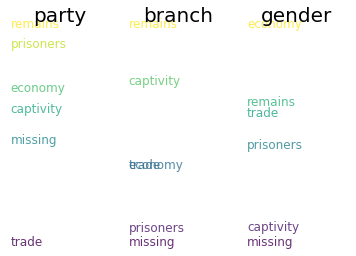

In [312]:
#Administration = dimension(nyt84W2V, ['reagan'], ['carter'])

Party = dimension(nyt94W2V, ['republican', 'conservative'], ['democrat', 'liberal'])

Gender = dimension(nyt94W2V, ['man'], ['woman'])

Branch = dimension(nyt94W2V, ['president'], ['congress', 'senate', 'house'])

def makeDF(model, word_list):
    g = []
    r = []
    c = []
    b = []
    for word in word_list:
        #g.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Administration.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nyt94W2V[word].reshape(1,-1), Party.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nyt94W2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        b.append(sklearn.metrics.pairwise.cosine_similarity(nyt94W2V[word].reshape(1,-1), Branch.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'party': r, 'gender': c, 'branch' : b}, index = word_list)
    return df

vietnamWarDF = makeDF(nyt94W2V, VietnamWar) 

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.viridis(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = .8, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())
    
fig = plt.figure(figsize = (6,4))
#ax1 = fig.add_subplot(141)
#PlotDimension(ax1, vietnamWarDF, 'administration')
ax1 = fig.add_subplot(131)
PlotDimension(ax1, vietnamWarDF, 'party')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, vietnamWarDF, 'branch')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, vietnamWarDF, 'gender')
plt.show()
fig.savefig('dimension94.png')

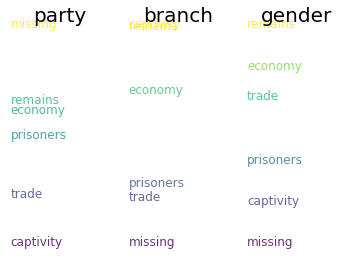

In [313]:
#Administration = dimension(nyt84W2V, ['reagan'], ['carter'])

Party = dimension(nyt99W2V, ['republican', 'conservative'], ['democrat', 'liberal'])

Gender = dimension(nyt99W2V, ['man'], ['woman'])

Branch = dimension(nyt99W2V, ['president'], ['congress', 'senate', 'house'])

def makeDF(model, word_list):
    g = []
    r = []
    c = []
    b = []
    for word in word_list:
        #g.append(sklearn.metrics.pairwise.cosine_similarity(nyt89W2V[word].reshape(1,-1), Administration.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nyt94W2V[word].reshape(1,-1), Party.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nyt94W2V[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        b.append(sklearn.metrics.pairwise.cosine_similarity(nyt94W2V[word].reshape(1,-1), Branch.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'party': r, 'gender': c, 'branch' : b}, index = word_list)
    return df

vietnamWarDF = makeDF(nyt99W2V, VietnamWar) 

def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.viridis(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = .8, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())
    
fig = plt.figure(figsize = (6,4))
#ax1 = fig.add_subplot(141)
#PlotDimension(ax1, vietnamWarDF, 'administration')
ax1 = fig.add_subplot(131)
PlotDimension(ax1, vietnamWarDF, 'party')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, vietnamWarDF, 'branch')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, vietnamWarDF, 'gender')
plt.show()
fig.savefig('dimension99.png')

# doc2vec

In [72]:
nytDF = nyt

def cleanerYear(x):
    return re.sub(r'(\D+)\s(\d{1,2})\W', '', x)

nytDF['date'] = nytDF['date'].apply(cleanerYear)
nytDF['docID'] = nytDF.index
nytDF['docID'] = nytDF['docID'].astype(str)


nytDF = nytDF.reset_index(drop=True)

In [73]:
keywords = ['missing', 'vietnam', 'war', 'prisoners', 'captivity', 'nixon', 'reagan', 'remains']

In [74]:
nytDF['tokenized_words'] = nytDF['article'].apply(lambda x: nltk.word_tokenize(x))
nytDF['normalized_words'] = nytDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [76]:
taggedDocs = []
for index, row in nytDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['date'])
    docKeywords.append(row['docID']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
nytDF['TaggedArticles'] = taggedDocs

In [77]:
nytD2V = gensim.models.doc2vec.Doc2Vec(nytDF['TaggedArticles'], size = 100) #Limiting to 100 dimensions

In [78]:
nytD2V.most_similar('missing')

[('unaccounted', 0.7162593007087708),
 ('listed', 0.6573542952537537),
 ('servicemen', 0.6111545562744141),
 ('remains', 0.5707314014434814),
 ('dead', 0.5617449879646301),
 ('fate', 0.5099062323570251),
 ('unknown', 0.49874138832092285),
 ('unknowns', 0.49828147888183594),
 ('alive', 0.4934026598930359),
 ('accounting', 0.486835777759552)]

In [80]:
nytD2V.most_similar( [ nytD2V.docvecs['16440'] ], topn=10) 

[('bellicosity', 0.5623066425323486),
 ('amiability', 0.5449433922767639),
 ('plausibly', 0.539766252040863),
 ('clarifying', 0.5348074436187744),
 ('purer', 0.5314168930053711),
 ('meaningless', 0.5260014533996582),
 ('patently', 0.516394317150116),
 ('expending', 0.5149837136268616),
 ('forbearance', 0.5087498426437378),
 ('utterly', 0.5085121393203735)]

In [57]:
nytDF.iloc[16440]['article']

"    The reason for all the theories that American prisoners of war remain alive in Indochina, almost two decades after the end of the Vietnam War, now becomes painfully clear. From 1973 on, official Washington misrepresented what it knew and shrugged off new leads, betraying its obligations to the families of the missing and to the public at large.  Even now, as a Senate select committee pursues its careful investigations, the White House has yet to offer any explanation or apology for the deceptions of Administrations past. The Vietnam syndrome cannot be declared properly buried until the executive branch itself sets the record straight on those missing in action, the M.I.A.'s.  It is too much to expect a resolution of every single case. That has not been possible in any war, and too much time has now gone by.  But it's hard to justify the Nixon Administration's public closing of this issue while the trail was still hot. In 1973, when Hanoi returned 591 American prisoners of war, the

# POW/MIA cluster

### Clustering

In [138]:
nytCluster = nyt

In [202]:
numCategories = 25

nytTFvectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
nytTFvects = nytTFvectorizer.fit_transform(nytCluster['article'])

myKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
myKM.fit(nytTFvects)

terms = nytTFvectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = myKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    try:
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
    except IndexError:
        pass
    print('\n')

Top terms per cluster:
Cluster 0:
 china
 chinese
 vietnamese
 border
 soviet
 relations
 foreign
 states
 military
 cambodia


Cluster 1:
 states
 percent
 government
 company
 type
 million
 world
 president
 date
 load


Cluster 2:
 reagan
 president
 policy
 administration
 nixon
 congress
 house
 foreign
 carter
 white


Cluster 3:
 senator
 republican
 democratic
 campaign
 party
 senate
 democrats
 state
 republicans
 president


Cluster 4:
 vietnamese
 hanoi
 refugees
 thailand
 thai
 cambodia
 states
 officials
 missing
 americans


Cluster 5:
 court
 judge
 case
 federal
 trial
 law
 lawyers
 justice
 supreme
 attorney


Cluster 6:
 film
 movie
 films
 movies
 directed
 director
 says
 story
 television
 life


Cluster 7:
 soviet
 union
 moscow
 afghanistan
 states
 russians
 nuclear
 military
 nations
 world


Cluster 8:
 a1
 president
 city
 clinton
 officials
 york
 federal
 plan
 state
 page


Cluster 9:
 bush
 president
 iraq
 clinton
 campaign
 vice
 republican
 george


In [139]:
numCategories = 30

nytTFvectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
nytTFvects = nytTFvectorizer.fit_transform(nytCluster['article'])

myKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
myKM.fit(nytTFvects)

terms = nytTFvectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = myKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    try:
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
    except IndexError:
        pass
    print('\n')

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=30, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

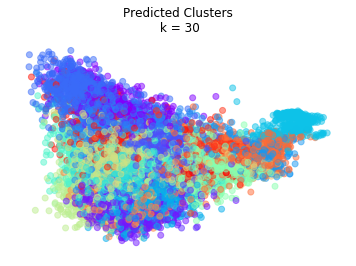

In [141]:
# visualize

nytPCA = sklearn.decomposition.PCA(n_components = 2).fit(nytTFvects.toarray())
reducedPCAdata = nytPCA.transform(nytTFvects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in myKM.labels_]

fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCAdata[:, 0], reducedPCAdata[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title("Predicted Clusters\n k = {}".format(numCategories))
plt.show()

In [155]:
nytCluster['cluster'] = myKM.labels_
nytCluster['cluster'] = nytCluster['cluster'].astype(str)
powCluster = nytCluster[nytCluster['cluster'].str.match('5', na = False)]
len(powCluster)
powCluster["docID"] = powCluster.index
powCluster = powCluster.reset_index(drop=True)

D:\computation\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### Linguistic Change

In [209]:
powLing = powCluster


In [210]:
# to make things easier for comparison, let's strip the date down from day-month-year to just year

import re

def cleanerYear(x):
    return re.sub(r'(\D+)\s(\d{1,2})\W', '', x)

def cleanFix(x):
    return re.sub(r'[^\d+]', '', x)

powLing['date'] = powLing['date'].apply(cleanerYear)
#powLing['date'] = powLing['date'].apply(cleanFix)

In [213]:
powLing['tokenized_sents'] = powLing['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
powLing['normalized_sents'] = powLing['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic) for s in x])

In [219]:
def calc_syn0norm(model):
    """since syn0norm is now depricated"""
    return (model.wv.syn0 / np.sqrt((model.wv.syn0 ** 2).sum(-1))[..., np.newaxis]).astype(np.float32)

def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
    (With help from William. Thank you!)
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """
    base_embed = copy.copy(base_embed)
    other_embed = copy.copy(other_embed)
    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the embedding matrices
    base_vecs = calc_syn0norm(in_base_embed)
    other_vecs = calc_syn0norm(in_other_embed)

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one
    # i.e. multiplying the embedding matrix (syn0norm)by "ortho"
    other_embed.wv.syn0norm = other_embed.wv.syn0 = (calc_syn0norm(other_embed)).dot(ortho)
    return other_embed
    
def intersection_align_gensim(m1,m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.vocab.keys())
    vocab_m2 = set(m2.wv.vocab.keys())

    # Find the common vocabulary
    common_vocab = vocab_m1&vocab_m2
    if words: common_vocab&=set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1-common_vocab and not vocab_m2-common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.vocab[w].count + m2.wv.vocab[w].count,reverse=True)

    # Then for each model...
    for m in [m1,m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.vocab[w].index for w in common_vocab]
        old_arr = calc_syn0norm(m)
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.syn0norm = m.wv.syn0 = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        m.index2word = common_vocab
        old_vocab = m.wv.vocab
        new_vocab = {}
        for new_index,word in enumerate(common_vocab):
            old_vocab_obj=old_vocab[word]
            new_vocab[word] = gensim.models.word2vec.Vocab(index=new_index, count=old_vocab_obj.count)
        m.wv.vocab = new_vocab

    return (m1,m2)

def compareModels(df, category, sort = True):
    """If you are using time as your category sorting is important"""
    embeddings_raw = {}
    cats = sorted(set(df[category]))
    for cat in cats:
        #This can take a while
        print("Embedding {}".format(cat), end = '\r')
        subsetDF = df[df[category] == cat]
        #You might want to change the W2V parameters
        embeddings_raw[cat] = gensim.models.word2vec.Word2Vec(subsetDF['normalized_sents'].sum())
    #These are much quicker
    embeddings_aligned = {}
    for catOuter in cats:
        embeddings_aligned[catOuter] = [embeddings_raw[catOuter]]
        for catInner in cats:
            embeddings_aligned[catOuter].append(smart_procrustes_align_gensim(embeddings_aligned[catOuter][-1], embeddings_raw[catInner]))
    return embeddings_raw, embeddings_aligned

In [220]:
rawEmbeddings, comparedEmbeddings = compareModels(powLing, 'date')

In [229]:
def getDivergenceDF(word, embeddingsDict):
    dists = []
    cats = sorted(set(embeddingsDict.keys()))
    dists = {}
    for cat in cats:
        dists[cat] = []
        for embed in embeddingsDict[cat][1:]:
            dists[cat].append(np.abs(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cat][0][word], axis = 0),
                                                                             np.expand_dims(embed[word], axis = 0))[0,0]))
    return pandas.DataFrame(dists, index = cats)

In [230]:
def findDiverence(word, embeddingsDict):
    cats = sorted(set(embeddingsDict.keys()))
    
    dists = []
    for embed in embeddingsDict[cats[0]][1:]:
        dists.append(1 - sklearn.metrics.pairwise.cosine_similarity(np.expand_dims(embeddingsDict[cats[0]][0][word], axis = 0), np.expand_dims(embed[word], axis = 0))[0,0])
    return sum(dists)

def findMostDivergent(embeddingsDict):
    words = []
    for embeds in embeddingsDict.values():
        for embed in embeds:
            words += list(embed.wv.vocab.keys())
    words = set(words)
    print("Found {} words to compare".format(len(words)))
    return sorted([(w, findDiverence(w, embeddingsDict)) for w in words], key = lambda x: x[1], reverse=True)
    

In [231]:
wordDivergences = findMostDivergent(comparedEmbeddings)
wordDivergences[:27]

Found 27 words to compare


[('would', 18.429503977298737),
 ('even', 18.046690822578967),
 ('north', 17.52782302722335),
 ('still', 17.391511756926775),
 ('first', 17.295836240518838),
 ('officials', 16.56882852036506),
 ('national', 16.04310953244567),
 ('americans', 15.59699885174632),
 ('war', 15.377209596335888),
 ('south', 15.286910980939865),
 ('last', 15.054173395037651),
 ('states', 14.675412096083164),
 ('government', 14.228241987526417),
 ('english', 14.077082219300792),
 ('said', 13.799795374274254),
 ('prisoners', 13.604897953569889),
 ('former', 13.504997208714485),
 ('military', 13.194222711026669),
 ('years', 12.742624454200268),
 ('political', 12.437028087675571),
 ('saigon', 12.237650871276855),
 ('united', 11.970090787857771),
 ('could', 11.866702742874622),
 ('hanoi', 11.762787073850632),
 ('american', 11.00703939050436),
 ('vietnamese', 10.998234808444977),
 ('vietnam', 9.661014080047607)]

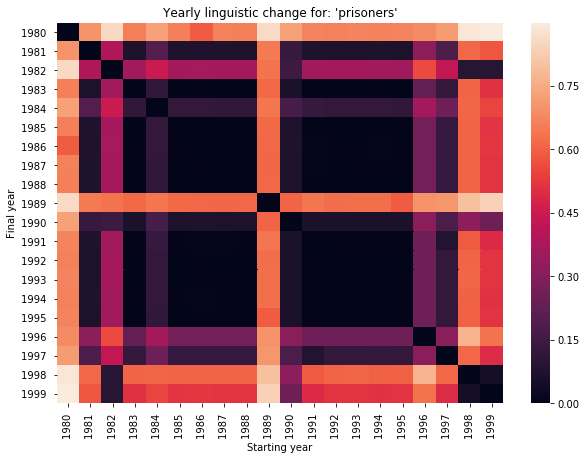

In [300]:
targetWord = 'prisoners'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()
fig.savefig('prisonersChange.png', bbox_inches='tight')

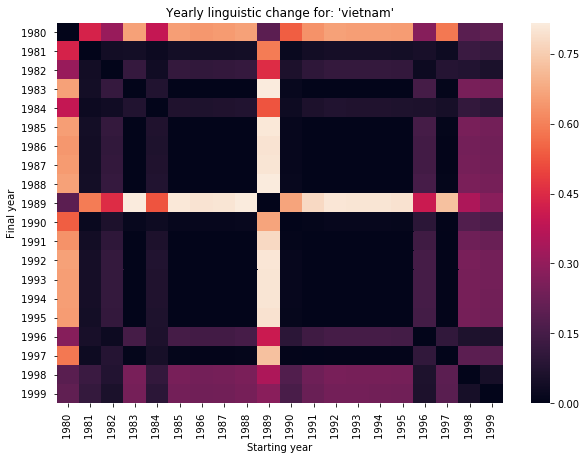

In [302]:
targetWord = 'vietnam'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()
fig.savefig('vietnamChange.png', bbox_inches='tight')

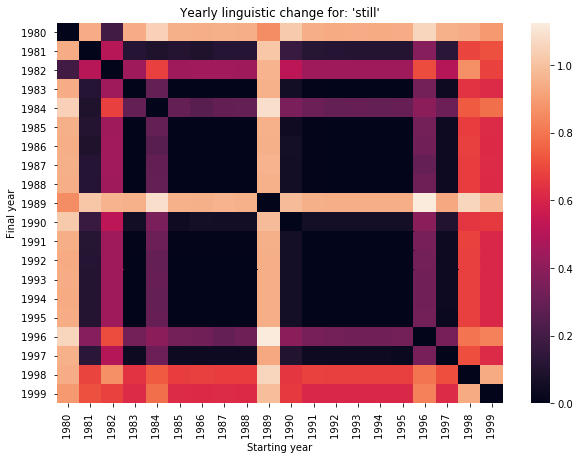

In [233]:
targetWord = 'still'

pltDF = getDivergenceDF(targetWord, comparedEmbeddings)
fig, ax = plt.subplots(figsize = (10, 7))
seaborn.heatmap(pltDF, ax = ax, annot = False) #set annot True for a lot more information
ax.set_xlabel("Starting year")
ax.set_ylabel("Final year")
ax.set_ylabel("Final year")
ax.set_title("Yearly linguistic change for: '{}'".format(targetWord))
plt.show()

In [327]:
powCluster.query('date == "1989"').date.count()

0

In [357]:
powCluster.to_csv('powTest.csv', index=False, header=True)

In [341]:
powCluster['date'].value_counts()

1992     94
1985     68
1993     57
1988     56
1986     56
1995     54
1994     53
1987     49
1991     35
1982     33
1981     28
1990     25
1984     23
1996     22
1997     22
1983     21
1980     20
1999     16
1998     15
1989      6
Name: date, dtype: int64

In [363]:
test = powCluster.set_index(['date'])
print(test.loc['1989'])

KeyError: 'the label [1989] is not in the [index]'

In [356]:
test

,article,cluster,docID,tokenized_sents,normalized_sents
date,,,,,
1980,"Neil Sheehan interview with Tran Ngoc Chau,...",5,14,"[[Neil, Sheehan, interview, with, Tran, Ngoc, ...","[[neil, sheehan, interview, tran, ngoc, chau, ..."
1980,Vietnam rejects UN Human Rights Commission ...,5,67,"[[Vietnam, rejects, UN, Human, Rights, Commiss...","[[vietnam, rejects, un, human, rights, commiss..."
1980,Pakistan plans to close its embassy in Hano...,5,93,"[[Pakistan, plans, to, close, its, embassy, in...","[[pakistan, plans, close, embassy, hanoi, citi..."
1980,Pakistan plans to close its embassy in Hano...,5,94,"[[Pakistan, plans, to, close, its, embassy, in...","[[pakistan, plans, close, embassy, hanoi, citi..."
1980,South Korean Information Minister Lee Kyoo ...,5,103,"[[South, Korean, Information, Minister, Lee, K...","[[south, korean, information, minister, lee, k..."
1980,To the Editor: Since the fall of South Vi...,5,219,"[[To, the, Editor, :, Since, the, fall, of, So...","[[editor, since, fall, south, vietnam, five, y..."
1980,WORLD NEWS BRIEFS; Racial Unrest to Be Cru...,5,225,"[[WORLD, NEWS, BRIEFS, ;, Racial, Unrest, to, ...","[[world, news, briefs, racial, unrest, crushed..."
1980,WORLD NEWS BRIEFS; Kenya Agrees to Expand ...,5,252,"[[WORLD, NEWS, BRIEFS, ;, Kenya, Agrees, to, E...","[[world, news, briefs, kenya, agrees, expand, ..."
1980,", Thailand, Oct. 6 Two United States offi...",5,293,"[[,, Thailand, ,, Oct., 6, Two, United, States...","[[thailand, two, united, states, officials, vi..."


In [351]:
powCluster.loc[powCluster['date'] == '1989']


,article,date,cluster,docID,tokenized_sents,normalized_sents


In [337]:
len(powCluster)

753

In [328]:
powCluster.query('date == "1991"').date.count()

0

In [325]:
powCluster[powCluster.date == '1989'].shape[0]

0

In [326]:
powCluster[powCluster.date == '1990'].shape[0]

0

In [321]:
len(powCluster['date'] == 1988)

753

In [ ]:
len(powCluster['date'] == 1990)

In [238]:
pow84 = powCluster[powCluster['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
pow89 = powCluster[powCluster['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
pow94 = powCluster[powCluster['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
pow99 = powCluster[powCluster['date'].str.contains('1980|1981|1982|1983|1984', na = False)]

pow84W2V = gensim.models.word2vec.Word2Vec(pow84['normalized_sents'].sum())
pow89W2V = gensim.models.word2vec.Word2Vec(pow89['normalized_sents'].sum())
pow94W2V = gensim.models.word2vec.Word2Vec(pow94['normalized_sents'].sum())
pow99W2V = gensim.models.word2vec.Word2Vec(pow99['normalized_sents'].sum())

In [292]:
pow84W2V.most_similar(positive=['president'])

[('vietcong', 0.999820351600647),
 ('hanoi', 0.9998172521591187),
 ('washington', 0.9998152256011963),
 ('american', 0.9998147487640381),
 ('may', 0.9998136758804321),
 ('saigon', 0.9998122453689575),
 ('former', 0.9998087286949158),
 ('government', 0.9998084902763367),
 ('political', 0.9998082518577576),
 ('military', 0.9998064637184143)]

In [293]:
pow89W2V.most_similar(positive=['president'])

[('vietcong', 0.9997908473014832),
 ('hanoi', 0.9997867345809937),
 ('saigon', 0.999785840511322),
 ('may', 0.9997857213020325),
 ('american', 0.9997854232788086),
 ('washington', 0.9997825622558594),
 ('political', 0.9997801780700684),
 ('government', 0.9997794032096863),
 ('vietnamese', 0.9997783899307251),
 ('could', 0.9997783899307251)]

In [290]:
pow94W2V.most_similar(positive=['president'])

[('communist', 0.9999431371688843),
 ('said', 0.9999411106109619),
 ('political', 0.9999375343322754),
 ('like', 0.9999368786811829),
 ('war', 0.999936580657959),
 ('would', 0.9999362230300903),
 ('one', 0.9999358057975769),
 ('american', 0.9999357461929321),
 ('military', 0.9999357461929321),
 ('americans', 0.999935507774353)]

In [291]:
pow99W2V.most_similar(positive=['president'])

[('communist', 0.9999461770057678),
 ('said', 0.9999415278434753),
 ('political', 0.9999411106109619),
 ('would', 0.9999392032623291),
 ('american', 0.9999386668205261),
 ('one', 0.9999384880065918),
 ('vietnam', 0.9999381303787231),
 ('country', 0.9999375343322754),
 ('military', 0.9999369978904724),
 ('vietnamese', 0.9999368190765381)]

### POS-Tagging

In [157]:
powInfo = powCluster

In [158]:
powInfo['sentences'] = powInfo['article'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
powInfo['POS_sents'] = powInfo['sentences'].apply(lambda x: stanford.postTagger.tag_sents(x))

In [159]:
countTarget = 'VB'
targetCounts = {}
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for ent, kind in sentence:
            if kind != countTarget:
                continue
            elif ent in targetCounts:
                targetCounts[ent] += 1
            else:
                targetCounts[ent] = 1
sortedTargets = sorted(targetCounts.items(), key = lambda x: x[1], reverse = True)
sortedTargets[:20]

[('be', 2165),
 ('have', 913),
 ('make', 255),
 ('take', 232),
 ('go', 197),
 ('do', 196),
 ('help', 191),
 ('get', 180),
 ('know', 148),
 ('see', 146),
 ('find', 136),
 ('say', 117),
 ('come', 115),
 ('leave', 112),
 ('allow', 108),
 ('give', 108),
 ('resolve', 106),
 ('begin', 103),
 ('provide', 99),
 ('open', 98)]

In [160]:
NTarget = 'JJ'
Word = 'prisoner'
NResults = set()
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'postwar', 'final', 'poltiical', 'former', 'war-time', 'large-scale', 'special', 'specific', 'Vietnamese', 'fellow', 'held', 'American', 'left'}


In [161]:
NTarget = 'JJ'
Word = 'prisoners'
NResults = set()
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'possible', 'several', 'American', 'many', 'unaccounted-for', 'missing', 'Chinese', 'dead', 'likely', 'last', 'military', 'additional', 'poltical', 'live', 'Other', 'well-known', 'former', 'known', 'Vietnamese-held', 'Vietnam-era', 'other', 'fellow', 'political', 'individual', 'new', 'tortured', 'such'}


In [365]:
NTarget = 'JJ'
Word = 'remains'
NResults = set()
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'possible', 'American', 'many', 'various', 'animal', 'supposed', 'partial', 'earthly', 'alleged', 'human', 'unidentifiable', 'unknown', 'further', 'recovered', 'unidentified', 'Few', 'fragmentary', 'specific', 'other', 'new', 'such'}


In [175]:
NTarget = 'VB'
Word = 'president'
NResults = set()
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'brief', 'meet', 'force', 'endorse', 'give', 'acquit', 'urge', 'carry'}


In [176]:
NTarget = 'VB'
Word = 'congress'
NResults = set()
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'consult', 'lead', 'lobby', 'give'}


In [177]:
NTarget = 'JJ'
Word = 'congress'
NResults = set()
for entry in powInfo['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'first', 'last', 'sixth', 'dubious', 'next', 'full', 'only', 'four-day', 'new', 'current', 'Republican-controlled', 'national', 'seventh', 'annual'}


In [197]:
powInfo84 = powInfo[powInfo['date'].str.contains('1980|1981|1982|1983|1984', na = False)]
powInfo89 = powInfo[powInfo['date'].str.contains('1985|1986|1987|1988|1989', na = False)]
powInfo94 = powInfo[powInfo['date'].str.contains('1990|1991|1992|1993|1994', na = False)]
powInfo99 = powInfo[powInfo['date'].str.contains('1995|1996|1997|1998|1999', na = False)]

In [198]:
NTarget = 'JJ'
Word = 'prisoners'
NResults = set()
for entry in powInfo84['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'former', 'Chinese', 'dead', 'fellow', 'political', 'American', 'many', 'well-known'}


In [199]:
NTarget = 'JJ'
Word = 'prisoners'
NResults = set()
for entry in powInfo89['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'possible', 'former', 'poltical', 'other', 'new', 'political', 'individual', 'fellow', 'American', 'live', 'such', 'Other', 'unaccounted-for'}


In [200]:
NTarget = 'JJ'
Word = 'prisoners'
NResults = set()
for entry in powInfo94['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'missing', 'possible', 'last', 'military', 'former', 'known', 'additional', 'Vietnamese-held', 'other', 'political', 'several', 'American', 'live', 'likely'}


In [201]:
NTarget = 'JJ'
Word = 'prisoners'
NResults = set()
for entry in powInfo99['POS_sents']:
    for sentence in entry:
        for (ent1, kind1),(ent2,kind2) in zip(sentence[:-1], sentence[1:]):
            if (kind1,ent2.lower())==(NTarget,Word):
                NResults.add(ent1)
            else:
                continue

print(NResults) 

{'former', 'Vietnam-era', 'other', 'political', 'American', 'tortured'}


### Information Retrieval

In [6]:
df80 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df80.csv')
df81 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df81.csv')
df82 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df82.csv')
df83 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df83.csv')
df84 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df84.csv')
df85 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df85.csv')
df86 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df86.csv')
df87 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df87.csv')
df88 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df88.csv')
df90 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df90.csv')
df91 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df91.csv')
df92 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df92.csv')
df93 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df93.csv')
df94 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df94.csv')
df95 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df95.csv')
df96 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df96.csv')
df97 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df97.csv')
df98 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df98.csv')
df99 = pandas.read_csv('D:/contentAnalysis/content-analysis-2018/finalProject/df99.csv')


In [7]:
frames = [df80, df81, df82, df83, df84, df85, df86, df87, df88, df90, df91, df92, df93, df94, df95, df96, df97, df98, df99]

In [8]:
ieDF = pandas.concat(frames)


In [11]:
ieDF['subject'].value_counts()

they                                      219
Vietnam                                   122
remains                                   100
meeting                                    86
United States                              75
it                                         72
Human remains                              63
Reagan Administration                      48
he                                         43
Hanoi                                      36
officials                                  35
American officials                         31
prisoners                                  28
It                                         28
envoy                                      27
Foreign Minister Nguyen Co Thach           26
delegation                                 24
team                                       24
Presidential envoy                         23
action                                     22
Vietnamese Foreign Minister                21
Foreign Minister                  

In [13]:
ieDF[ieDF['subject'] == 'prisoners']['verb'].value_counts()

were left              16
were                    7
were released under     2
were released by        1
is in                   1
were held during        1
Name: verb, dtype: int64

In [14]:
ieDF[ieDF['object'] == 'prisoners']['verb'].value_counts()

indeed still hold    1
hold                 1
still hold           1
indeed hold          1
Name: verb, dtype: int64

In [17]:
ieDF[ieDF['subject'] == 'prisoners']

,certainty,subject,verb,object
4,1.0,prisoners,is in,Vietnam
9,1.0,prisoners,were left,forces withdrew in 1973
10,1.0,prisoners,were left,when American forces withdrew from South Vietnam
11,1.0,prisoners,were left,when American forces withdrew from South Vietn...
12,1.0,prisoners,were left,American forces withdrew in 1973
13,1.0,prisoners,were left,American forces withdrew
14,1.0,prisoners,were left,when American forces withdrew in 1973
15,1.0,prisoners,were left,forces withdrew from South Vietnam in 1973
16,1.0,prisoners,were left,when American forces withdrew
17,1.0,prisoners,were left,when forces withdrew from South Vietnam in 1973


In [22]:
ieDF[ieDF['object'] == 'prisoners']

,certainty,subject,verb,object
145,1.0,Vietnam,hold,prisoners
146,1.0,Vietnam,still hold,prisoners
148,1.0,Vietnam,indeed still hold,prisoners
150,1.0,Vietnam,indeed hold,prisoners


In [192]:
ieDF[ieDF['object'] == 'missing']

,certainty,subject,verb,object
358,1.0,"1,369 Americans",listed,missing
361,1.0,Americans,listed,missing
115,1.0,Americans,still listed,missing
118,1.0,Americans,listed,missing
27,1.0,Americans,reported,missing
